In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.7"   # allow 70% max
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"


In [1]:
import jax
import jax.numpy as jnp
import optax
from jax import random, grad, value_and_grad
from jax import nn

import numpy as np
import os
import dill
from matplotlib import pyplot as plt

from lib.lib_ARFF_r import (
    Functions,
    ARFFHyperparameters,
    ARFFTrain,
    nll_loss
)

from lib.plot_lib import (
    PlotResults
)

PR = PlotResults(Functions)

print(jax.devices())
print(jnp.sin(jnp.pi/2))

%load_ext autoreload
%autoreload 2

[CudaDevice(id=0)]
1.0


In [2]:
# import sqlite3
# import pandas as pd
# import yfinance as yf

# # ---------------------------
# # 1. Download full SPY history
# # ---------------------------
# df = yf.download("SPY", period="max", group_by="ticker")

# # Flatten MultiIndex if present
# if isinstance(df.columns, pd.MultiIndex):
#     df.columns = [col[1] if col[1] else col[0] for col in df.columns]

# # Use Adj Close if available, else Close
# if "Adj Close" in df.columns:
#     df = df[["Adj Close"]].rename(columns={"Adj Close": "SPY"})
# else:
#     df = df[["Close"]].rename(columns={"Close": "SPY"})

# # Reset index so Date becomes a column named 'date'
# df = df.reset_index().rename(columns={"Date": "date"})

# # Ensure proper dtypes
# df["date"] = pd.to_datetime(df["date"])
# df["SPY"] = df["SPY"].astype(float)

# # ---------------------------
# # 2. Replace table in your DB
# # ---------------------------
# db_path = "training_data/market_data.db"   # adjust path if needed
# table_name = "SPY_spot"

# conn = sqlite3.connect(db_path)
# df.to_sql(table_name, conn, if_exists="replace", index=False)
# conn.close()

# print(f"✅ Saved {len(df)} rows into {table_name} in {db_path}")
# print(df.head())
# print(df.tail())

In [3]:
import sqlite3
import pandas as pd
import numpy as np

def build_and_store_Xt(db_path, table_name):
    # ---------------------------
    # 1. Load SPY spot prices
    # ---------------------------
    conn = sqlite3.connect(db_path)
    df = pd.read_sql(f"SELECT date, SPY FROM {table_name} ORDER BY date", conn)
    conn.close()

    df['date'] = pd.to_datetime(df['date'])
    df['log_spot'] = np.log(df['SPY'])

    # ---------------------------
    # 2. Compute log returns
    # ---------------------------
    df['r_t'] = df['log_spot'].diff()

    # ---------------------------
    # 3. Build lagged returns r_t-1 ... r_t-4
    # ---------------------------
    for lag in range(1, 5):
        df[f'r_t-{lag}'] = df['r_t'].shift(lag)

    # ---------------------------
    # 4. Rolling means (5, 20, 60)
    # ---------------------------
    df['r_5'] = df['r_t'].rolling(5).mean()
    df['r_20'] = df['r_t'].rolling(20).mean()
    df['r_60'] = df['r_t'].rolling(60).mean()

    # ---------------------------
    # 5. Rolling std (5,20,60)
    # ---------------------------
    df['sigma_5'] = df['r_t'].rolling(5).std()
    df['sigma_20'] = df['r_t'].rolling(20).std()
    df['sigma_60'] = df['r_t'].rolling(60).std()

    # ---------------------------
    # 6. EWM mean and std (span=5)
    # ---------------------------
    df['ewm_mean_5'] = df['r_t'].ewm(span=5, adjust=False).mean()
    df['ewm_std_5'] = df['r_t'].ewm(span=5, adjust=False).std()

    # ---------------------------
    # 7. Squared and absolute returns
    # ---------------------------
    df['r_t_sq'] = df['r_t'].shift(1)**2
    df['r_t_abs'] = df['r_t'].shift(1).abs()

    # ---------------------------
    # 8. Cyclical date features
    # ---------------------------
    df['weekday'] = df['date'].dt.weekday
    df['day_of_year'] = df['date'].dt.dayofyear
    df['year'] = df['date'].dt.year

    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12)
    df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)
    df['day_sin'] = np.sin(2 * np.pi * (df['day'] - 1) / 31)
    df['day_cos'] = np.cos(2 * np.pi * (df['day'] - 1) / 31)

    # Normalize year to [0,1]
    df['year_norm'] = (df['year'] - df['year'].min()) / (df['year'].max() - df['year'].min())

    # ---------------------------
    # IMPORTANT: Do not drop rows!
    # Keep NaNs for early dates (so alignment is preserved)
    # ---------------------------

    return df


In [33]:
if __name__ == "__main__":
    db_path = "training_data/market_data.db"
    table_name = "SPY_spot"
    df = build_and_store_Xt(db_path, table_name)
    print(df.head(15))
    print("Final shape:", df.shape)


feature_cols = [
    'r_t-1', 'r_t-2', 'r_t-3', 'r_t-4',
    'r_5', 'r_20', 'r_60',
    'sigma_5', 'sigma_20', 'sigma_60',
    'ewm_mean_5', 'ewm_std_5',
    'r_t_sq', 'r_t_abs',
    'weekday_sin', 'weekday_cos',
    'month_sin', 'month_cos',
    'day_sin', 'day_cos',
    'year_norm'
]

feature_cols = [
    'r_t-1', 'r_t-2', 'r_t-3', 'r_t-4',
    'r_5', 'r_20', 'r_60',
    'sigma_5', 'sigma_20', 'sigma_60',
    'r_t_sq', 'r_t_abs',
    'weekday_sin', 'weekday_cos',
    'month_sin', 'month_cos',
    'day_sin', 'day_cos',
    'year_norm'
]

X_t = df[feature_cols].copy()
y_t = df['r_t'].copy()  # target values

# ---------------------------
# Drop rows where any features are NaN
# This automatically keeps X and y aligned
# ---------------------------
valid_idx = X_t.dropna().index
X_t = X_t.loc[valid_idx].reset_index(drop=True)
y_t = y_t.loc[valid_idx].reset_index(drop=True)

print("Feature matrix shape:", X_t.shape)
print("Target vector shape:", y_t.shape)
print(X_t.head())
print(y_t.head())

         date        SPY  log_spot       r_t     r_t-1     r_t-2     r_t-3  \
0  1993-01-29  24.380444  3.193781       NaN       NaN       NaN       NaN   
1  1993-02-01  24.553846  3.200869  0.007087       NaN       NaN       NaN   
2  1993-02-02  24.605883  3.202986  0.002117  0.007087       NaN       NaN   
3  1993-02-03  24.865973  3.213500  0.010515  0.002117  0.007087       NaN   
4  1993-02-04  24.970009  3.217675  0.004175  0.010515  0.002117  0.007087   
5  1993-02-05  24.952675  3.216981 -0.000694  0.004175  0.010515  0.002117   
6  1993-02-08  24.952675  3.216981  0.000000 -0.000694  0.004175  0.010515   
7  1993-02-09  24.779249  3.210007 -0.006974  0.000000 -0.000694  0.004175   
8  1993-02-10  24.813965  3.211407  0.001400 -0.006974  0.000000 -0.000694   
9  1993-02-11  24.935329  3.216286  0.004879  0.001400 -0.006974  0.000000   
10 1993-02-12  24.744593  3.208607 -0.007679  0.004879  0.001400 -0.006974   
11 1993-02-16  24.120342  3.183056 -0.025551 -0.007679  0.004879

In [34]:
h = 1

x_data = X_t.to_numpy()[::h, :]
r_data = y_t.to_numpy().reshape(-1, 1)[::h, :]

print(x_data.shape)
print(r_data.shape)





#h = 1 #days
diff_type = "diagonal"
key = random.PRNGKey(0)

(8152, 19)
(8152, 1)


In [35]:
# ARFF parameters
val_split = 0.1
ARFF_val_split = 0.1

drift_hyperparam = ARFFHyperparameters(K=2**8,
                                        M_min=100,
                                        M_max=500,
                                        lambda_reg=2e-2,
                                        gamma=1,
                                        delta=0.05,
                                        name='drift')
diff_hyperparam = ARFFHyperparameters(K=drift_hyperparam.K,
                                       M_min=100,
                                       M_max=drift_hyperparam.M_max,
                                       lambda_reg=1e-4,
                                       gamma=drift_hyperparam.gamma,
                                       delta=0.02,
                                       name='diffusion')


drift epoch: 265


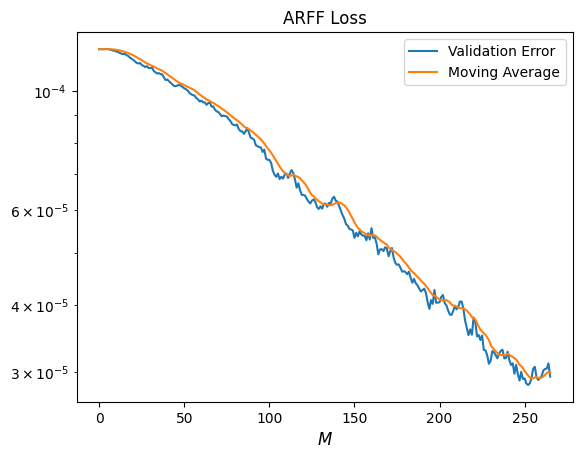

False
(7337, 1)
diffusion epoch: 100


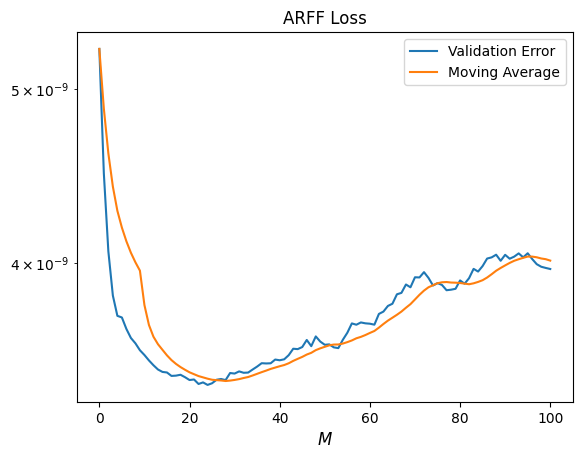

loss = 0.0002, val_loss = 11.7394, time = 37.7850s


In [36]:
# train ARFF
ARFF = ARFFTrain(resampling=True, metropolis_test=True)

drift_param, diff_param, time, loss, val_loss, z, Sigma = ARFF.train_model(key, drift_hyperparam, diff_hyperparam, x_data, r_data, h, val_split=val_split, ARFF_val_split=ARFF_val_split, diff_type=diff_type)


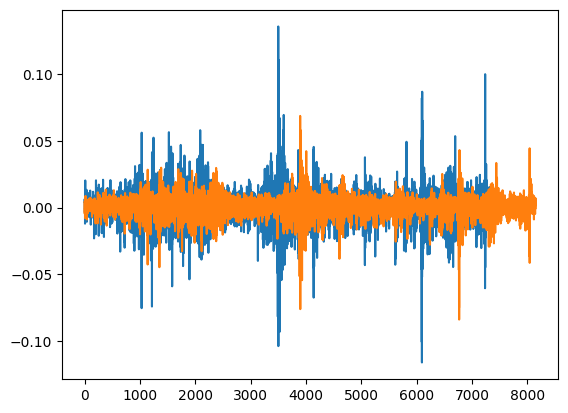

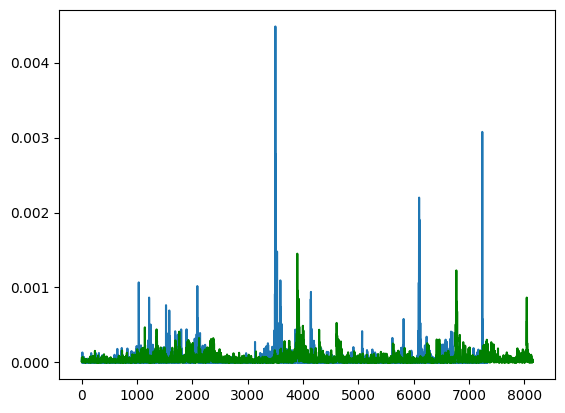

In [37]:
plt.figure()
plt.plot(z)
plt.plot(h * Functions.drift(drift_param, x_data))

plt.figure()
plt.plot(Sigma)
plt.plot(Functions.diffusion(diff_param, x_data, diff_type)[:, :, 0] ** 2, color='green')
# print(np.mean(Functions.drift(drift_param, x_data)))
# print(Functions.diffusion(diff_param, x_data, diff_type))
# print(Sigma)

In [38]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from jax import random, lax, vmap
import matplotlib.pyplot as plt

# -------------------------
# Helpers: preprocess dates -> numeric features (outside JAX)
# -------------------------
def preprocess_dates(pd_dates):
    """Return jnp array (T, n_date_feats)."""
    if not isinstance(pd_dates, pd.Series):
        pd_dates = pd.Series(pd_dates)
    year_min = pd_dates.dt.year.min()
    year_max = pd_dates.dt.year.max()

    feats = []
    for d in pd_dates:
        weekday = d.weekday()
        day_of_year = d.dayofyear
        month = d.month
        day = d.day
        weekday_sin = np.sin(2 * np.pi * weekday / 7)
        weekday_cos = np.cos(2 * np.pi * weekday / 7)
        month_sin = np.sin(2 * np.pi * (month - 1) / 12)
        month_cos = np.cos(2 * np.pi * (month - 1) / 12)
        day_sin = np.sin(2 * np.pi * (day - 1) / 31)
        day_cos = np.cos(2 * np.pi * (day - 1) / 31)
        year_norm = (d.year - year_min) / (year_max - year_min)
        feats.append([weekday, day_of_year, month, day,
                      weekday_sin, weekday_cos,
                      month_sin, month_cos,
                      day_sin, day_cos,
                      year_norm])
    return jnp.array(feats)  # shape (T, 11)

# -------------------------
# JAX feature builders (pure jnp)
# -------------------------
def rolling_mean_jax(x, window):
    return jnp.mean(x[-window:])

def rolling_std_jax(x, window):
    return jnp.std(x[-window:])

def ewm_mean_jax(x, span=5):
    alpha = 2.0 / (span + 1.0)
    n = x.shape[0]
    pows = jnp.arange(n-1, -1, -1)   # newest has highest weight
    w = (1.0 - alpha) ** pows
    w = w / jnp.sum(w)
    return jnp.sum(w * x)

def ewm_std_jax(x, span=5):
    mu = ewm_mean_jax(x, span)
    n = x.shape[0]
    pows = jnp.arange(n-1, -1, -1)
    alpha = 2.0 / (span + 1.0)
    w = (1.0 - alpha) ** pows
    w = w / jnp.sum(w)
    var = jnp.sum(w * (x - mu)**2)
    return jnp.sqrt(var)

def build_features(r_hist, date_feat_row):
    """Return feature vector (jnp array) matching your feature_cols ordering."""
    f = []
    # lagged returns r_t-1 ... r_t-4 (most recent is r_hist[-1])
    for lag in range(1, 5):
        f.append(r_hist[-lag])
    # rolling means
    f.append(rolling_mean_jax(r_hist, 5))
    f.append(rolling_mean_jax(r_hist, 20))
    f.append(rolling_mean_jax(r_hist, 60))
    # rolling stds
    f.append(rolling_std_jax(r_hist, 5))
    f.append(rolling_std_jax(r_hist, 20))
    f.append(rolling_std_jax(r_hist, 60))
    # # EWM mean/std
    # f.append(ewm_mean_jax(r_hist, span=5))
    # f.append(ewm_std_jax(r_hist, span=5))
    # # squared / abs of most recent
    f.append(r_hist[-1] ** 2)
    f.append(jnp.abs(r_hist[-1]))
    # date features: date_feat_row = [weekday, day_of_year, month, day,
    # weekday_sin, weekday_cos, month_sin, month_cos, day_sin, day_cos, year_norm]
    weekday_sin = date_feat_row[4]
    weekday_cos = date_feat_row[5]
    month_sin = date_feat_row[6]
    month_cos = date_feat_row[7]
    day_sin = date_feat_row[8]
    day_cos = date_feat_row[9]
    year_norm = date_feat_row[10]
    f.extend([weekday_sin, weekday_cos, month_sin, month_cos, day_sin, day_cos, year_norm])
    return jnp.array(f)   # shape (F,)

# -------------------------
# log_return (JAX). Assumes Functions.drift and diffusion are JAX-compiled and accept jnp arrays
# -------------------------
def log_return(key, drift_param, diff_param, x, h, diff_type):
    x = jnp.atleast_2d(x)                 # (1, F)
    key, subkey = random.split(key)
    # scalar dW for d=1
    dW = random.normal(subkey, shape=()) * jnp.sqrt(h)
    mu = Functions.drift(drift_param, x)                # (1, d)
    sigma_mat = Functions.diffusion(diff_param, x, diff_type)  # (1, d, d)
    # extract scalar sigma if d=1
    sigma_scalar = jnp.reshape(sigma_mat, (sigma_mat.shape[0], -1))[:, 0]  # (1,)
    r = mu[:, 0] * h + sigma_scalar * dW            # (1,)
    return r, key

# -------------------------
# single trajectory via lax.scan
# -------------------------
def generate_single_traj(key, drift_param, diff_param, r_init, spy_init,
                         date_features, start_end_idx, h, diff_type, n_steps, r_min, r_max):
    """
    r_init: jnp array (L,) oldest..newest
    date_features: jnp array (T, n_date_feats)
    start_end_idx: integer (Python int) index of the last known observed row (end of r_init)
    We will simulate indices start_end_idx+1 .. start_end_idx+n_steps
    """
    L = r_init.shape[0]
    idxs = jnp.arange(start_end_idx + 1, start_end_idx + 1 + n_steps)

    def step(carry, idx):
        key, r_hist, spy = carry
        date_feat_row = date_features[idx]    # jnp array (11,)
        x = build_features(r_hist, date_feat_row)  # (F,)
        r_new_arr, key = log_return(key, drift_param, diff_param, x, h, diff_type)
        r_new = r_new_arr[0]
        # Clip to training range (keeps scan/jit friendly). You can modify later.
        r_new = jnp.clip(r_new, r_min, r_max)
        spy_new = spy * jnp.exp(r_new)
        # shift history
        r_hist = jnp.concatenate([r_hist[1:], jnp.array([r_new])])
        return (key, r_hist, spy_new), (r_new, spy_new)

    init_carry = (key, r_init, spy_init)
    (key_out, r_hist_out, spy_out), (r_seq, spy_seq) = lax.scan(step, init_carry, idxs)
    return r_seq, spy_seq

# -------------------------
# batched trajectories with vmap
# -------------------------
def generate_trajectories(key, drift_param, diff_param, r_init, spy_init,
                          date_features, start_end_idx, h, diff_type, n_steps, N, r_min, r_max):
    # replicate initial conditions
    r_init_batch = jnp.tile(r_init[None, :], (N, 1))   # (N, L)
    spy_init_batch = jnp.full((N,), spy_init)
    keys = random.split(key, N)
    vm = vmap(generate_single_traj,
              in_axes=(0, None, None, 0, 0, None, None, None, None, None, None, None),
              out_axes=(0,0))
    r_seqs, spy_seqs = vm(keys, drift_param, diff_param, r_init_batch, spy_init_batch,
                          date_features, start_end_idx, h, diff_type, n_steps, r_min, r_max)
    return r_seqs, spy_seqs    # shapes (N, n_steps), (N, n_steps)

# -------------------------
# Utility: pick first contiguous window of L valid returns
# -------------------------
def find_first_valid_window(df, L=60):
    arr_valid = (~df['r_t'].isna()).astype(int).to_numpy()
    if len(arr_valid) < L:
        raise ValueError("Not enough rows for a window")
    window_sum = np.convolve(arr_valid, np.ones(L, dtype=int), mode='valid')  # length n-L+1
    idxs = np.where(window_sum == L)[0]
    if len(idxs) == 0:
        raise ValueError("No contiguous window of length L without NaN found")
    start_idx = idxs[0]
    end_idx = start_idx + L - 1
    return start_idx, end_idx

# -------------------------
# === Example wiring ===
# -------------------------
# df: your pandas table (master) with 'date' (datetime), 'SPY', 'r_t' (may have NaNs)
# Ensure df exists and Functions, drift_param, diff_param, diff_type defined.

L = 60
# find first contiguous window of L valid returns (no NaNs)
start_idx, end_idx = find_first_valid_window(df, L=L)
print("Using window start,end:", start_idx, end_idx)

# initial history (oldest..newest)
r_init = jnp.array(df['r_t'].iloc[start_idx:end_idx+1].to_numpy(), dtype=jnp.float64)  # shape (L,)
spy_init = float(df['SPY'].iloc[end_idx])  # SPY corresponding to last of r_init

# date_features for whole dataset (JAX array)
date_features = preprocess_dates(df['date'])   # shape (T, 11)

# training bounds
r_min = float(df['r_t'].min())
r_max = float(df['r_t'].max())

# parameters
key = random.PRNGKey(1)
N = 100      # number of trajectories
T_steps = 8000

# run (this returns JAX arrays)
r_seqs, spy_seqs = generate_trajectories(key, drift_param, diff_param,
                                        r_init, spy_init, date_features,
                                        end_idx, 1.0, diff_type,
                                        T_steps, N, r_min, r_max)

print("r_seqs.shape:", r_seqs.shape)     # (N, T_steps)
print("spy_seqs.shape:", spy_seqs.shape) # (N, T_steps)



Using window start,end: 1 60
r_seqs.shape: (100, 8000)
spy_seqs.shape: (100, 8000)


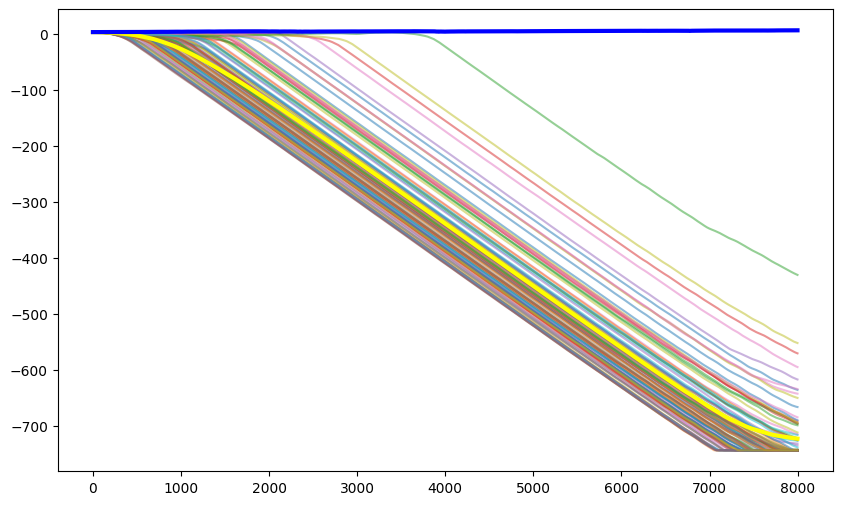

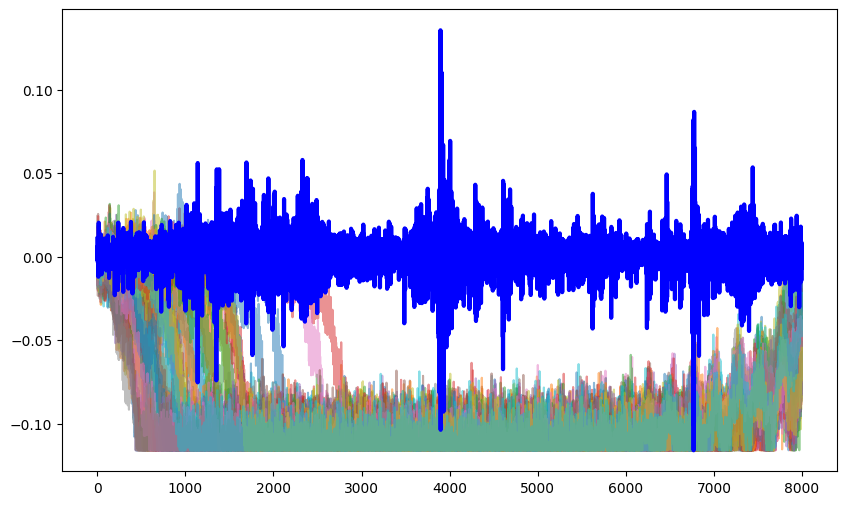

In [39]:
x = np.arange(T_steps)

spy_seqs_np = np.asarray(spy_seqs)
spy_mean = np.log(spy_seqs_np).mean(axis=0)
plt.figure(figsize=(10,6))
for i in range(min(100, spy_seqs_np.shape[0])):
    plt.plot(np.log(spy_seqs_np[i]), alpha=0.5)

plt.plot(x, spy_mean, color='yellow', linewidth=3, zorder=5)
plt.plot(x, np.log(df['SPY'][60:(T_steps+60)]), color='blue', linewidth=3, zorder=10)

r_seqs_np = np.asarray(r_seqs)
plt.figure(figsize=(10,6))
for i in range(min(50, r_seqs_np.shape[0])):
    plt.plot(r_seqs_np[i], alpha=0.5)

plt.plot(x, df['r_t'][60:(T_steps+60)], color='blue', linewidth=3, zorder=10)


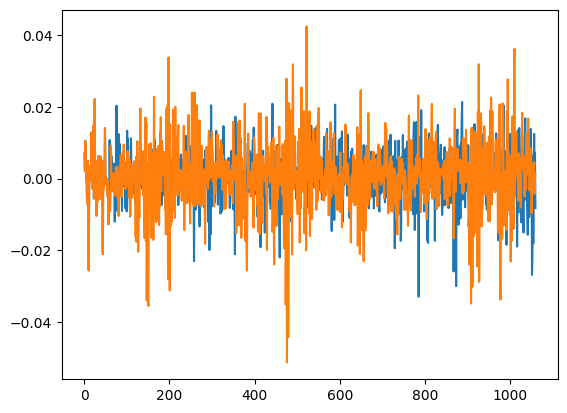

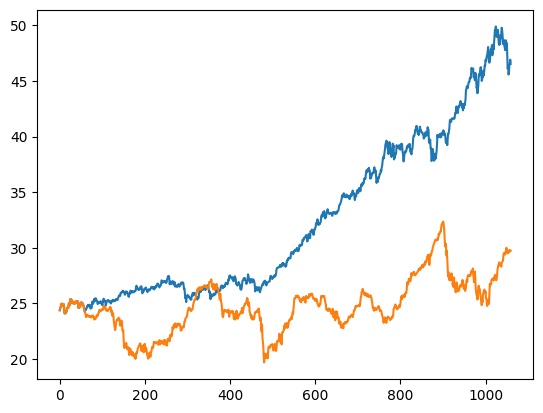

In [44]:
#print(df_traj['r_t'][50:110])
plt.figure()
plt.plot(df['r_t'][:(T+60)])
plt.plot(df_traj['r_t'])

plt.figure()
plt.plot(df['SPY'][:(T+60)])
plt.plot(df_traj['SPY'])

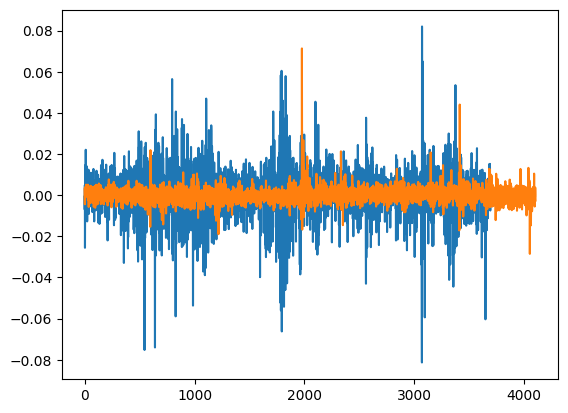

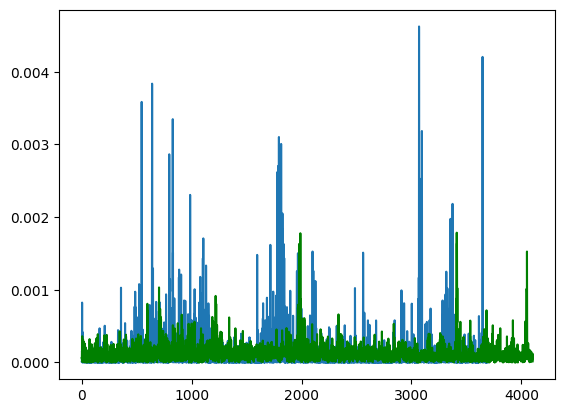

In [58]:
plt.figure()
plt.plot(z)
plt.plot(h * Functions.drift(drift_param, x_data))

plt.figure()
plt.plot(Sigma)
plt.plot(Functions.diffusion(diff_param, x_data, diff_type)[:, :, 0] ** 2, color='green')
# print(np.mean(Functions.drift(drift_param, x_data)))
# print(Functions.diffusion(diff_param, x_data, diff_type))
# print(Sigma)

In [202]:
key = random.PRNGKey(8)

def log_return(key, drift_param, diff_param, x, h, diff_type):
    key, subkey = random.split(key)
    dW = random.normal(subkey, shape=(drift_param["amp"].shape[1], jnp.atleast_2d(x).shape[0])) * jnp.sqrt(h)
    r = h * Functions.drift(drift_param, x) + Functions.diffusion(diff_param, x, diff_type)[:, :, 0] * dW
    #print(h * Functions.drift(drift_param, x), Functions.diffusion(diff_param, x, diff_type)[:, :, 0] * dW, dW)
    #print(dW.shape, Functions.drift(drift_param, x).shape, Functions.diffusion(diff_param, x, diff_type)[:, :, 0].shape)
    return r

import pandas as pd
import numpy as np
from jax import random

def generate_trajectory(key, drift_param, diff_param, df_initial, h, diff_type, n_steps):
    """
    df_initial: pandas DataFrame with columns ['date', 'SPY', 'r_t']
                first 60 rows should contain actual SPY and r_t values
                remaining rows can be NaN
    h: time step
    n_steps: number of new log returns to generate
    """
    df_traj = df_initial.copy()
    
    # pre-compute year min/max for normalization
    year_min, year_max = df_traj['date'].dt.year.min(), df_traj['date'].dt.year.max()
    
    for i in range(60, 60 + n_steps):
        # ---------------------------
        # 1. Build X_t for current step
        # ---------------------------
        recent = df_traj.iloc[i-60:i].copy()  # last 60 r_t values
        
        X_row = {}
        # lagged returns
        for lag in range(1, 5):
            X_row[f'r_t-{lag}'] = recent['r_t'].iloc[-lag]
        # # rolling means
        X_row['r_5'] = recent['r_t'].iloc[-5:].mean()
        X_row['r_20'] = recent['r_t'].iloc[-20:].mean()
        X_row['r_60'] = recent['r_t'].mean()
        # rolling std
        X_row['sigma_5'] = recent['r_t'].iloc[-5:].std()
        X_row['sigma_20'] = recent['r_t'].iloc[-20:].std()
        X_row['sigma_60'] = recent['r_t'].std()
        # EWM mean/std (span=5)
        X_row['ewm_mean_5'] = recent['r_t'].ewm(span=5, adjust=False).mean().iloc[-1]
        X_row['ewm_std_5'] = recent['r_t'].ewm(span=5, adjust=False).std().iloc[-1]
        # squared / absolute
        # X_row['r_t_sq'] = recent['r_t'].iloc[-1]**2
        # X_row['r_t_abs'] = abs(recent['r_t'].iloc[-1])
        # date features (from pre-existing date)
        date = df_traj['date'].iloc[i]  # use the i-th date from df_initial
        X_row['weekday'] = date.weekday()
        X_row['day_of_year'] = date.dayofyear
        X_row['year'] = date.year
        X_row['weekday_sin'] = np.sin(2 * np.pi * X_row['weekday'] / 7)
        X_row['weekday_cos'] = np.cos(2 * np.pi * X_row['weekday'] / 7)
        X_row['month'] = date.month
        X_row['day'] = date.day
        X_row['month_sin'] = np.sin(2 * np.pi * (date.month - 1) / 12)
        X_row['month_cos'] = np.cos(2 * np.pi * (date.month - 1) / 12)
        X_row['day_sin'] = np.sin(2 * np.pi * (date.day - 1) / 31)
        X_row['day_cos'] = np.cos(2 * np.pi * (date.day - 1) / 31)
        # normalize year
        X_row['year_norm'] = (date.year - year_min) / (year_max - year_min)
        
        # convert to DataFrame / array
        X_new = pd.DataFrame([X_row])[list(feature_cols)]
        
        # ---------------------------
        # 2. Generate new log return
        # ---------------------------
        key, subkey = random.split(key)
        r_new = log_return(key, drift_param, diff_param, X_new.values, h, diff_type)[0, 0]
        if r_new > df['r_t'].max() or r_new < df['r_t'].min():
            return df_traj
        
        # ---------------------------
        # 3. Update df_traj
        # ---------------------------
        df_traj.at[i, 'r_t'] = r_new
        df_traj.at[i, 'SPY'] = df_traj['SPY'].iloc[i-1] * np.exp(r_new)
    
    return df_traj


# start with all dates
df_initial = df[['date']].copy()

# create SPY and r_t columns filled with NaN
df_initial['SPY'] = np.nan
df_initial['r_t'] = np.nan

# fill only the first 60 rows
df_initial.loc[:59, 'SPY'] = df['SPY'].iloc[:60].values
df_initial.loc[:59, 'r_t'] = df['r_t'].iloc[:60].values

n_traj = 1000
df_traj = generate_trajectory(key, drift_param, diff_param, df_initial, 1, diff_type, n_traj)

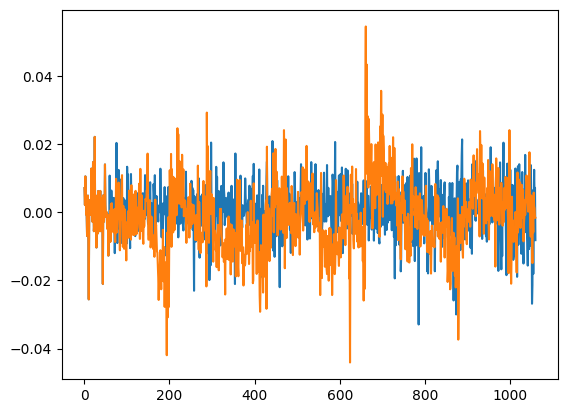

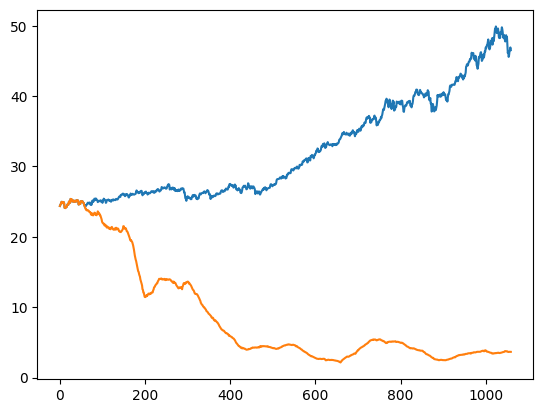

In [203]:
#print(df_traj['r_t'][50:110])
plt.figure()
plt.plot(df['r_t'][:(n_traj+60)])
plt.plot(df_traj['r_t'])

plt.figure()
plt.plot(df['SPY'][:(n_traj+60)])
plt.plot(df_traj['SPY'])

(695, 1)
(695, 1, 1)
(695, 1)
(695, 1)
(695, 1)
(695, 1)
(695, 1) (695, 1)


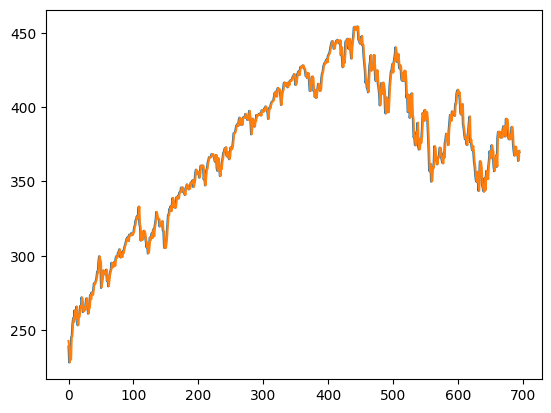

In [66]:
print(Functions.drift(drift_param, x_data).shape)
print(Functions.diffusion(diff_param, x_data, diff_type).shape)

def BS_drift(drift_param, diff_param, x, diff_type, S):
    f = Functions.drift(drift_param, x)
    sigma = Functions.diffusion(diff_param, x, diff_type)
    return (f - 0.5 * sigma[:, :, 0] ** 2) * S
    
def BS_diffusion(diff_param, x, diff_type, S):
    return (Functions.diffusion(diff_param, x, diff_type)[:, :, 0] * S)

def BS_EM_step(key, drift_param, diff_param, x, h, diff_type, S0):
    key, subkey = random.split(key)
    dW = random.normal(subkey, shape=S0.shape) * jnp.sqrt(h)
    print(dW.shape)
    print(BS_diffusion(diff_param, x, diff_type, S0).shape)
    print((BS_diffusion(diff_param, x, diff_type, S0) * dW).shape)
    S1 = S0 + h * BS_drift(drift_param, diff_param, x, diff_type, S0) + BS_diffusion(diff_param, x, diff_type, S0) * dW
    return S1


print(BS_drift(drift_param, diff_param, x_data, diff_type, 1).shape)
#print(BS_diffusion(diff_param, x_data, diff_type, 1).shape)
S1 = BS_EM_step(key, drift_param, diff_param, x_data, h, diff_type, S_data)
print(S_data.shape, S1.shape)

from matplotlib import pyplot as plt
#plt.scatter(S_data, S1)
plt.plot(S1)
plt.plot(S_data)

In [ ]:
# generate trjaectories for BS


In [16]:
PR.plot_train_v_true(drift_param, x_data)
PR.plot_train_v_true(diff_param, x_data, diff_type=diff_type)
print(nll_loss(drift_param, diff_param, x_data, y_data, h, diff_type))
print(drift_param["amp"].shape)

TypeError: 'NoneType' object is not callable

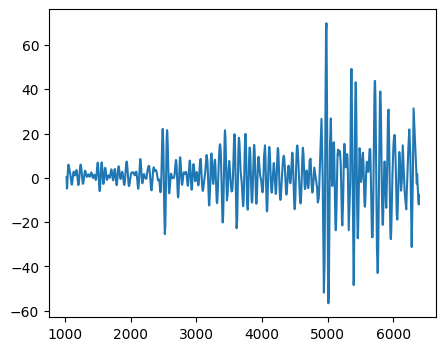

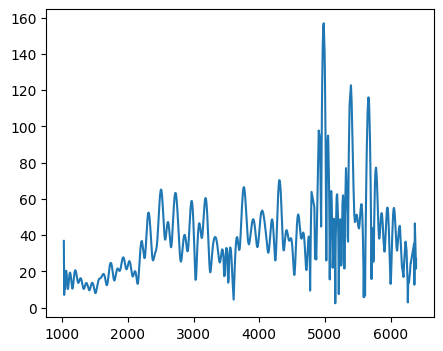

In [70]:
PR.plot_train_v_true(drift_param, x_data)
PR.plot_train_v_true(diff_param, x_data, diff_type=diff_type)

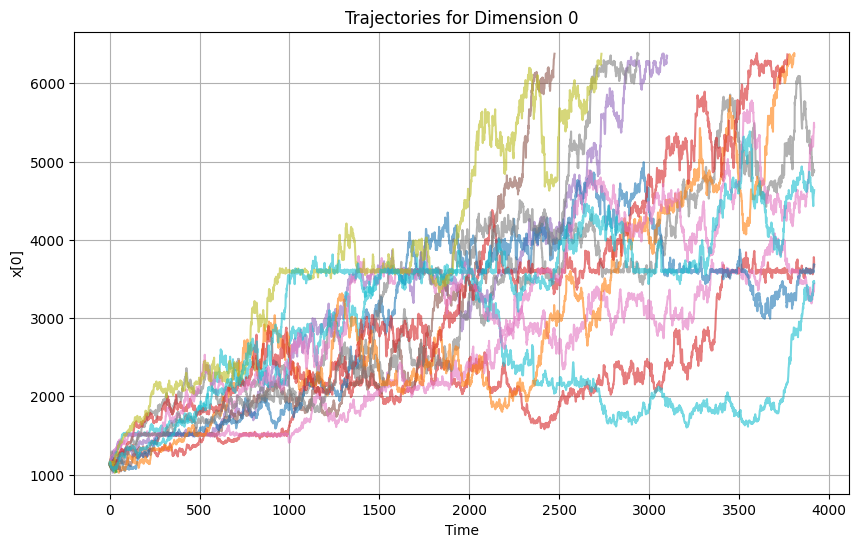

Array([[[1133.        , 1113.17761344, 1138.85271729, ...,
                   nan,           nan,           nan]],

       [[1133.        , 1158.7671849 , 1162.18421451, ...,
                   nan,           nan,           nan]],

       [[1133.        , 1145.77542819, 1156.12022453, ...,
                   nan,           nan,           nan]],

       ...,

       [[1133.        , 1141.97729517, 1145.03769187, ...,
                   nan,           nan,           nan]],

       [[1133.        , 1166.80687765, 1163.08605898, ...,
                   nan,           nan,           nan]],

       [[1133.        , 1161.36008616, 1156.78450919, ...,
         4620.27194192, 4605.94048115, 4634.39130492]]], dtype=float64)

In [71]:
x_domain = np.array([[1133, 1133]])
xlim = np.array([[min(x_data), max(x_data)]])

n_trajectories = 20
trajectory_time = 3918
step_size = 1

PR.plot_trajectories(drift_param, diff_param, x_domain, xlim, n_trajectories, trajectory_time, h, diff_type)

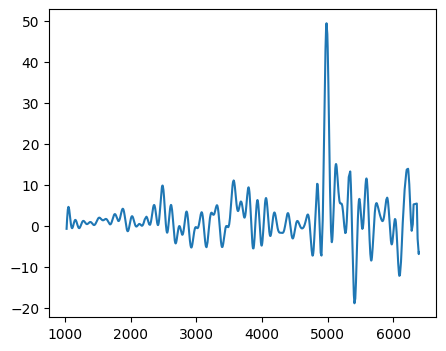

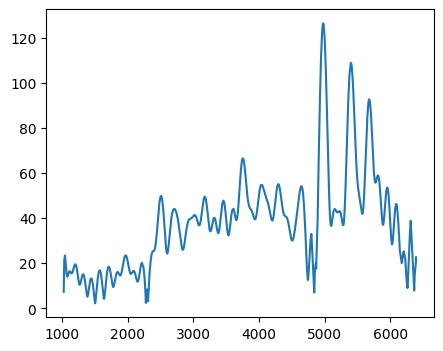

In [62]:
PR.plot_train_v_true(drift_param, x_data)
PR.plot_train_v_true(diff_param, x_data, diff_type=diff_type)

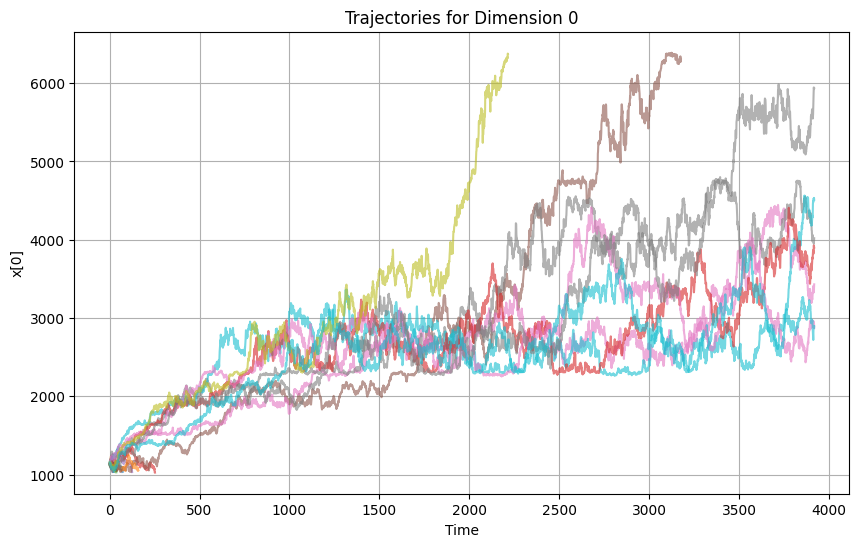

Array([[[1133.        , 1111.52791329, 1133.85730914, ...,
                   nan,           nan,           nan]],

       [[1133.        , 1156.11358614, 1159.68940974, ...,
                   nan,           nan,           nan]],

       [[1133.        , 1143.40791254, 1156.64365171, ...,
                   nan,           nan,           nan]],

       ...,

       [[1133.        , 1139.69341577, 1142.31726361, ...,
         5944.72678265, 5923.57988055, 5931.52294607]],

       [[1133.        , 1163.97624199, 1156.70535153, ...,
                   nan,           nan,           nan]],

       [[1133.        , 1158.64939079, 1150.44520746, ...,
         2897.46144865, 2871.93813499, 2890.91187359]]], dtype=float64)

In [63]:
x_domain = np.array([[1133, 1133]])
xlim = np.array([[min(x_data), max(x_data)]])

n_trajectories = 20
trajectory_time = 3918
step_size = 1

PR.plot_trajectories(drift_param, diff_param, x_domain, xlim, n_trajectories, trajectory_time, h, diff_type)

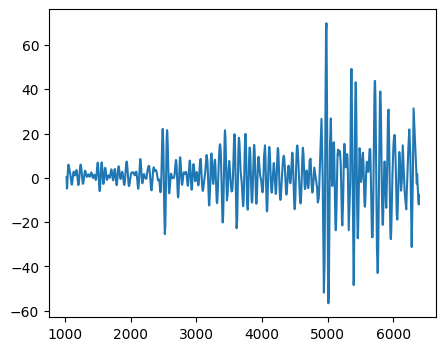

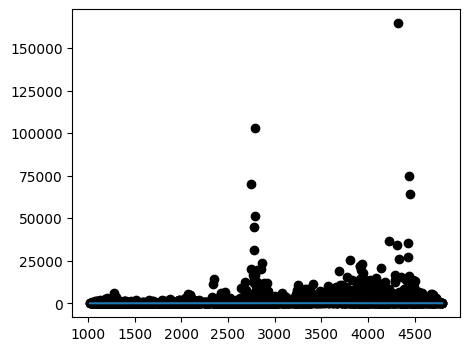

[[2.03232261e-06]
 [7.57493169e-05]
 [4.52902200e-04]
 ...
 [7.51098353e+04]
 [1.02864365e+05]
 [1.64676664e+05]]


In [11]:
plot_train_v_true(drift_param, x_data)
plot_train_v_true(diff_param, x_data, diff_type=diff_type, z=Sigma)
print(np.sort(Sigma, axis=0))

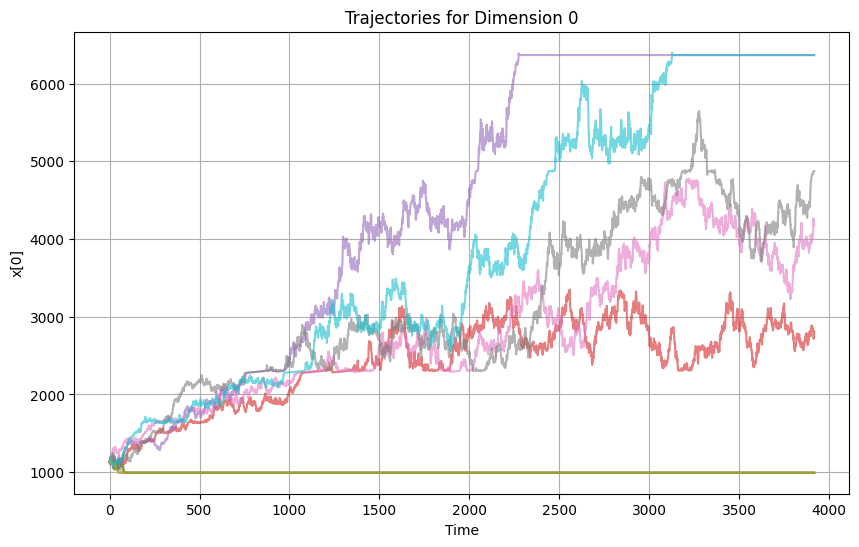

Array([[[1133.        , 1111.52791329, 1098.64095621, ...,
          993.29916816,  993.29916834,  993.2991685 ]],

       [[1133.        , 1156.11358614, 1163.93359653, ...,
          993.29916855,  993.29916803,  993.29916823]],

       [[1133.        , 1143.40791254, 1136.07339769, ...,
          993.29916774,  993.2991683 ,  993.29916892]],

       ...,

       [[1133.        , 1152.83334738, 1160.32843858, ...,
         4875.15271656, 4875.78754111, 4873.69754957]],

       [[1133.        , 1111.06095674, 1142.22106658, ...,
          993.29916842,  993.29916793,  993.29916842]],

       [[1133.        , 1151.51595503, 1177.83621487, ...,
         6366.23062224, 6366.23062207, 6366.23062229]]], dtype=float64)

In [43]:
x_domain = np.array([[1133, 1133]])

n_trajectories = 10
trajectory_time = 3918
step_size = 1

plot_trajectories(drift_param, diff_param, x_domain, n_trajectories, trajectory_time, h, diff_type)

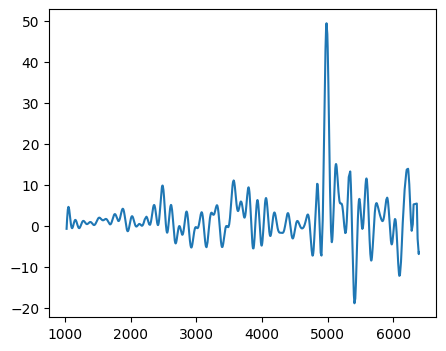

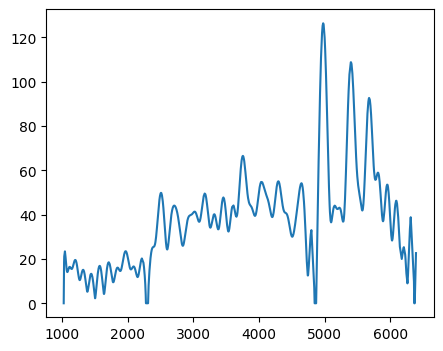

In [41]:
plot_train_v_true(drift_param, x_data)
plot_train_v_true(diff_param, x_data, diff_type=diff_type)

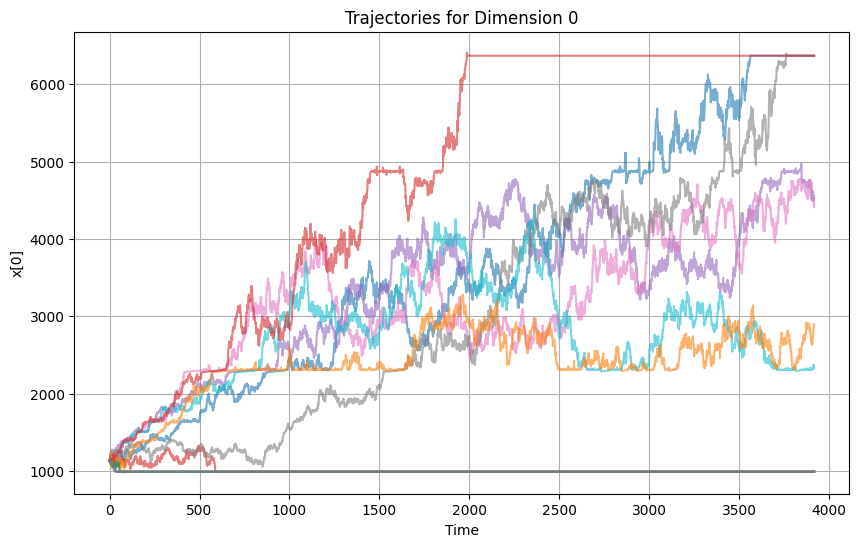

Array([[[1133.        , 1111.52791329, 1109.39638691, ...,
         6366.23062166, 6366.2306217 , 6366.23062246]],

       [[1133.        , 1156.11358614, 1172.07285831, ...,
          993.29916831,  993.29916857,  993.29916849]],

       [[1133.        , 1143.40791254, 1150.55055251, ...,
          993.29916813,  993.29916849,  993.29916829]],

       ...,

       [[1133.        , 1124.9687445 , 1147.28695872, ...,
          993.2991684 ,  993.29916826,  993.29916825]],

       [[1133.        , 1140.04984241, 1149.4538478 , ...,
         6366.23062267, 6366.23062166, 6366.23062164]],

       [[1133.        , 1138.77095032, 1154.32145902, ...,
          993.29916794,  993.29916831,  993.29916878]]], dtype=float64)

In [42]:
x_domain = np.array([[1133, 1133]])

n_trajectories = 15
trajectory_time = 3918
step_size = 1

plot_trajectories(drift_param, diff_param, x_domain, n_trajectories, trajectory_time, h, diff_type)

In [17]:

np.savez(f"saved_results/param/{data_name}_ARFF.npz", drift_param=drift_param, diff_param=diff_param, diff_type=diff_type, times=time, losses=loss, val_losses=val_loss)
